In [56]:
# Install dependencies
!pip install aif360[all]==0.6.0 pandas seaborn matplotlib scikit-learn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 29.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 14.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [73]:
from aif360.sklearn.datasets import fetch_compas

X, y = fetch_compas(
    subset='all',
    binary_race=True,
    dropna=True,
    numeric_only=True
)
print("Features shape:", X.shape)
print("Labels shape:", y.shape)

Features shape: (5278, 9)
Labels shape: (5278,)


In [74]:
import pandas as pd
from aif360.datasets import StandardDataset

df = X.copy()
df['label'] = y

# Flatten columns and index
df.columns = df.columns.map(str)
df = df.reset_index(drop=True)

dataset = StandardDataset(
    df=df,
    label_name='label',
    favorable_classes=[0],
    protected_attribute_names=['race'],
    privileged_classes=[[1]],
    categorical_features=[],
    features_to_keep=df.columns.tolist(),
    features_to_drop=[],
    na_values=[]
)
print("✅ Dataset ready with", dataset.features.shape[0], "rows")

✅ Dataset ready with 5278 rows


In [75]:
train, test = dataset.split([0.7], shuffle=True)
print("Train shape:", train.features.shape, "| Test shape:", test.features.shape)

Train shape: (3694, 9) | Test shape: (1584, 9)


In [76]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

scaler = StandardScaler().fit(train.features)
clf = LogisticRegression(solver='liblinear')
clf.fit(scaler.transform(train.features), train.labels.ravel())

test_pred = test.copy()
test_pred.labels = clf.predict(scaler.transform(test.features))

In [77]:
from aif360.metrics import ClassificationMetric

priv = [{'race': 1.0}]
unpriv = [{'race': 0.0}]

metric = ClassificationMetric(
    test, test_pred,
    privileged_groups=priv,
    unprivileged_groups=unpriv
)

fpr_priv = metric.false_positive_rate(privileged=True)
fpr_unpriv = metric.false_positive_rate(privileged=False)
print(f"Baseline FPR gap (Unpriv − Priv): {fpr_unpriv - fpr_priv:.3f}")

Baseline FPR gap (Unpriv − Priv): -0.321


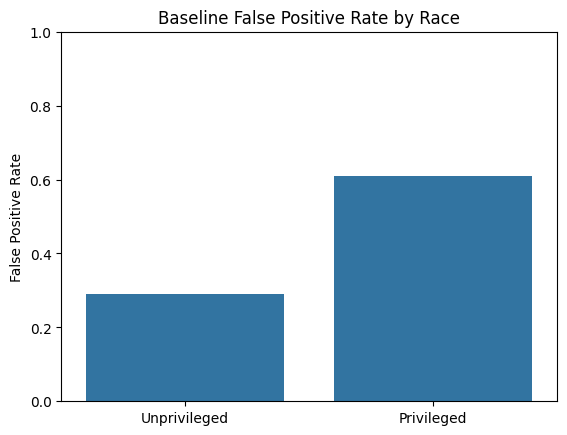

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(
    x=["Unprivileged", "Privileged"],
    y=[fpr_unpriv, fpr_priv]
)
plt.title("Baseline False Positive Rate by Race")
plt.ylabel("False Positive Rate")
plt.ylim(0, 1)
plt.show()



In [79]:
from aif360.algorithms.preprocessing import Reweighing

rw = Reweighing(unprivileged_groups=unpriv, privileged_groups=priv)
rw.fit(train)
train_rw = rw.transform(train)

clf_rw = LogisticRegression(solver='liblinear')
clf_rw.fit(
    StandardScaler().fit_transform(train_rw.features),
    train_rw.labels.ravel(),
    sample_weight=train_rw.instance_weights
)

test_pred_rw = test.copy()
test_pred_rw.labels = clf_rw.predict(scaler.transform(test.features))


In [80]:
metric_rw = ClassificationMetric(
    test, test_pred_rw,
    privileged_groups=priv,
    unprivileged_groups=unpriv
)

fpr_priv_rw = metric_rw.false_positive_rate(privileged=True)
fpr_unpriv_rw = metric_rw.false_positive_rate(privileged=False)
print(f"Post‑mitigation FPR gap: {fpr_unpriv_rw - fpr_priv_rw:.3f}")

Post‑mitigation FPR gap: 0.046


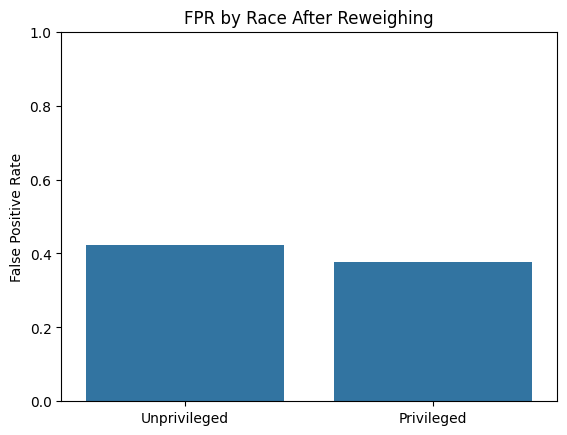

In [81]:
sns.barplot(
    x=["Unprivileged", "Privileged"],
    y=[fpr_unpriv_rw, fpr_priv_rw]
)
plt.title("FPR by Race After Reweighing")
plt.ylabel("False Positive Rate")
plt.ylim(0, 1)
plt.show()

In [82]:
# Ensure metric and metric_rw are already defined from earlier steps

def summarize_bias_metrics(metric, metric_rw):
    fpr_priv = metric.false_positive_rate(privileged=True)
    fpr_unpriv = metric.false_positive_rate(privileged=False)
    fpr_gap = fpr_unpriv - fpr_priv

    fpr_priv_rw = metric_rw.false_positive_rate(privileged=True)
    fpr_unpriv_rw = metric_rw.false_positive_rate(privileged=False)
    fpr_gap_rw = fpr_unpriv_rw - fpr_priv_rw

    print("📌 Privileged group: race = 1 (Caucasian)")
    print("📌 Unprivileged group: race = 0 (African-American)\n")

    print("🔹 Baseline Metrics:")
    print(f"   FPR – Privileged:     {fpr_priv:.3f}")
    print(f"   FPR – Unprivileged:   {fpr_unpriv:.3f}")
    print(f"   FPR Gap:              {fpr_gap:.3f}\n")

    print("🔹 Post-Mitigation Metrics (Reweighing):")
    print(f"   FPR – Privileged:     {fpr_priv_rw:.3f}")
    print(f"   FPR – Unprivileged:   {fpr_unpriv_rw:.3f}")
    print(f"   FPR Gap:              {fpr_gap_rw:.3f}")

# Run the summary
summarize_bias_metrics(metric, metric_rw)


📌 Privileged group: race = 1 (Caucasian)
📌 Unprivileged group: race = 0 (African-American)

🔹 Baseline Metrics:
   FPR – Privileged:     0.611
   FPR – Unprivileged:   0.290
   FPR Gap:              -0.321

🔹 Post-Mitigation Metrics (Reweighing):
   FPR – Privileged:     0.377
   FPR – Unprivileged:   0.423
   FPR Gap:              0.046
